<a href="https://colab.research.google.com/github/MarcLefevreFr/OpenClassrooms/blob/master/P6/P6_TL_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On refait tout en utilisant, pour le transfert learning, les fonction preprocess_input


### **Préliminaires**<br>**Import :**<br>- google drive<br>- données<br>- bibliothèques python

In [ ]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# récupe des zip d'images et extractions
import shutil
import os
import zipfile
from time import time

start = time()
cwd = os.getcwd()

shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train.zip"), cwd)

# données "low" = image originales mais juste les 30 première classes
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test_light.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train_light.zip"), cwd)



with zipfile.ZipFile(cwd + "/test.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/test_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

print(f"Import & extraction des data : {time()-start:.0f} secondes.")

Import & extraction des data : 79 secondes.


In [ ]:
# vérif
import os
# chemin des répertoires contenant les photos
PATH_TRAIN = "train"
PATH_TRAIN_l = "train_light"
PATH_TEST = "test"
PATH_TEST_l = "test_light"

len(os.listdir(PATH_TRAIN)), len(os.listdir(PATH_TEST)), len(os.listdir(PATH_TRAIN_l)), len(os.listdir(PATH_TEST_l))

(120, 120, 30, 30)

In [ ]:
# Import python
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import PIL.ImageOps as ops
import os
import pickle
import random as rd
import warnings

from time import time

import keras
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

from keras.applications.vgg16 import preprocess_input as prepro_vgg
from keras.applications.inception_resnet_v2 import preprocess_input as prepro_in
from tensorflow.keras.applications.efficientnet import preprocess_input as prepro_eff

# Ignorance de certains avertissements
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
print(tensorflow.__version__)

2.4.1


In [ ]:
# Def de constantes

BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
#NB_TRAIN_light = 4917 # nb original
NB_TEST = 8193

TRAIN_STEPS = NB_TRAIN // BATCH
#TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
#VAL_STEPS_light = TRAIN_STEPS_light // 5

TEST_STEPS = NB_TEST // BATCH

print(TRAIN_STEPS, VAL_STEPS, TEST_STEPS)

2316 463 256


In [ ]:
def modelize(model, nb_epochs, train_gen, val_gen, train_steps, val_steps, mod_name, opti = "adam", verbose = 0):

    
    #mod_save_path = "drive/MyDrive/P6/Data/models/" + mod_name + ".hdf5"
    mod_save_path = "drive/MyDrive/P6/Data/models/" + mod_name

    check = ModelCheckpoint(mod_save_path,
                            save_weights_only = True,
                            monitor = "val_accuracy",
                            save_best_only = True)
    
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opti,
                  metrics = ['accuracy'])

    start = time()

    history = model.fit(train_gen,
                        steps_per_epoch = train_steps,
                        epochs = nb_epochs,
                        validation_data = val_gen,
                        validation_steps = val_steps,
                        verbose = verbose,
                        callbacks = check)
    
    model.save("drive/MyDrive/P6/Data/models/" + mod_name)
    pickle.dump(history.history, open("drive/MyDrive/P6/Data/models/" + mod_name + "_hist.pickle", "wb" ))

    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, nb_epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, nb_epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    print()
    print(f"Temps d'entrainements pour {nb_epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.3f}, meilleure val_acc = {np.max(val_acc):.3f}")
    print()

    plt.show()

# ICI LES GENERATEUR FONT APPEL AUX FONCTIONS preprocess_input de chaque modèle qui sera utilisé
# et on ne fait plus de normalisation "manuelle"
def create_generator(batch, train_folder, size = (100, 100), prep = None):

    generators = []

    train_datagen = ImageDataGenerator(preprocessing_function=prep,
                                       #rescale = 1./255#, # normalisation
                                       #rotation_range = 15,
                                       #horizontal_flip=True,
                                       #validation_split = 0.2
                                       )

    val_datagen = ImageDataGenerator(preprocessing_function = prep,
                                     #rescale = 1./255,
                                     rotation_range = 15,
                                     zoom_range = 0.1,
                                     fill_mode = "reflect"
                                    )

    train_gen = train_datagen.flow_from_directory(train_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )

    val_gen = val_datagen.flow_from_directory(train_folder,
                                            target_size = size,
                                            batch_size = batch,
                                            class_mode = "categorical",
                                            seed = SEED,
                                            interpolation = "nearest"
                                            )
    
    return train_gen, val_gen


def create_test_generators(batch, test_folder, size = (100, 100), prep = None):

    # générateur d'images test, juste la normalisation
    test_datagen = ImageDataGenerator(preprocessing_function = prep)

    test_gen = test_datagen.flow_from_directory(test_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )
    
    return test_gen

    # RECUP DU DICO DES CLASSES :
    # ---> mon_generator.class_indices


def eval_model(model, test_gen, steps):

    loss, acc = model.evaluate(test_gen, steps = steps)
    print(f"L'accuracy du model est : acc = {acc:.3f}")

## **Transfert**

In [ ]:
# import vgg16 sans les couches denses
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


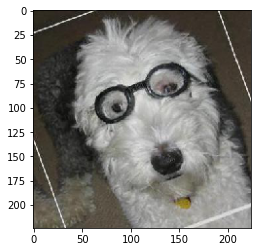

In [ ]:
# SAMPLE KERAS

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)


# on passe une image dans le réseau
path ="train" + "/" + os.listdir("train")[0] + "/" + os.listdir("train" + "/" +os.listdir("train")[0])[0]

img = image.load_img(path, target_size=(224, 224))

plt.imshow(img)

In [ ]:
# transformation en array
x = image.img_to_array(img)
x.shape

(224, 224, 3)

In [ ]:
# on rajoute une dims, comme si l'image était dans un batch de une image
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [ ]:
# preprocessing propre à vgg 16... change pas les dims mais les valeurs...
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [ ]:
# prediction avec VGG
feat = model_VGG16.predict(x)

In [ ]:
# il en ressort l'output de VGG, cad les 512 feat-maps au format 11*11
feat.shape

(1, 7, 7, 512)

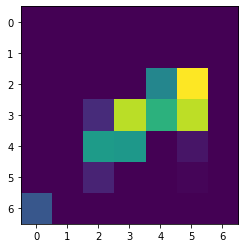

In [ ]:
# affichage de la featmap[x]
plt.imshow(feat[0, :, :, 225])

# **Transfert Learning VGG16**

In [ ]:
# import vgg16 sans les couches denses
model_VGG16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16.layers :
    layer.trainable = False

In [ ]:
# partie dense
# entrée
x = model_VGG16.layers[-1].output
# applatissement
x = Flatten()(x)
# couche Dense 120 sortie directe
preds = Dense(120, activation = "softmax")(x)

# Def du modèle totale
mod_vgg16 = Model(inputs = model_VGG16.input, outputs = preds)

In [ ]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_vgg)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.


In [ ]:
# récupération et sauvegarde de la liste d'étiquette (qui sera toujours la même)...
dict_labels = train_gen.class_indices
pickle.dump(dict_labels, open("drive/MyDrive/P6/Data/models/" + "dict_labels.pickle", "wb" ))

Epoch 1/10
2316/2316 [==============================] - 417s 172ms/step - loss: 52.0602 - accuracy: 0.5073 - val_loss: 16.4824 - val_accuracy: 0.8497
Epoch 2/10
2316/2316 [==============================] - 394s 170ms/step - loss: 13.8089 - accuracy: 0.8873 - val_loss: 15.5956 - val_accuracy: 0.8782
Epoch 3/10
2316/2316 [==============================] - 395s 170ms/step - loss: 11.1382 - accuracy: 0.9196 - val_loss: 14.3151 - val_accuracy: 0.9027
Epoch 4/10
2316/2316 [==============================] - 394s 170ms/step - loss: 9.0993 - accuracy: 0.9406 - val_loss: 13.3501 - val_accuracy: 0.9123
Epoch 5/10
2316/2316 [==============================] - 392s 169ms/step - loss: 7.8117 - accuracy: 0.9527 - val_loss: 11.2795 - val_accuracy: 0.9291
Epoch 6/10
2316/2316 [==============================] - 395s 170ms/step - loss: 6.5019 - accuracy: 0.9614 - val_loss: 11.8357 - val_accuracy: 0.9336
Epoch 7/10
2316/2316 [==============================] - 393s 170ms/step - loss: 6.4574 - accuracy: 0.96

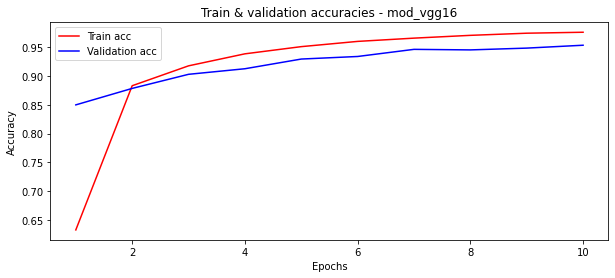

In [ ]:
modelize(mod_vgg16, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16", "adam", 1)

In [ ]:
#mod_path = "drive/MyDrive/P6/Data/models/" + "mod_vgg16.hdf5"
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_vgg16"

mod_vgg16 = load_model(mod_path)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 485s 201ms/step - loss: 4.5348 - accuracy: 0.9815 - val_loss: 11.3064 - val_accuracy: 0.9496
Epoch 2/5
2316/2316 [==============================] - 454s 196ms/step - loss: 4.4328 - accuracy: 0.9822 - val_loss: 9.6944 - val_accuracy: 0.9550
Epoch 3/5
2316/2316 [==============================] - 452s 195ms/step - loss: 3.8694 - accuracy: 0.9845 - val_loss: 10.2455 - val_accuracy: 0.9538
Epoch 4/5
2316/2316 [==============================] - 449s 194ms/step - loss: 4.1140 - accuracy: 0.9854 - val_loss: 10.5034 - val_accuracy: 0.9549
Epoch 5/5
2316/2316 [==============================] - 449s 194ms/step - loss: 3.9452 - accuracy: 0.9857 - val_loss: 10.4733 - val_accuracy: 0.9579
Temps d'entrainements pour 5 epochs : 2293 secondes.
Meilleure train_acc = 0.985, meilleure val_acc = 0.958



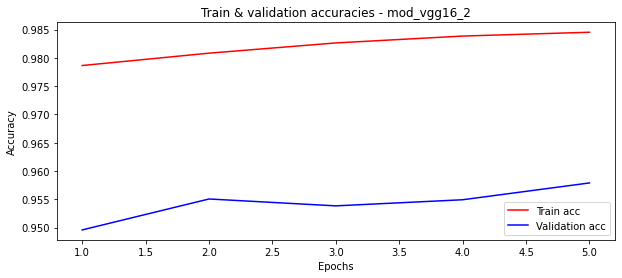

In [ ]:
# On continue sur 5 epochs vu que le modèle n'overfit pas...
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_vgg)
modelize(mod_vgg16, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16_2", "adam", 1)

## **Fine Tuning VGG16**<br>

In [ ]:
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_vgg16_2"
mod_vgg16_2_FT = load_model(mod_path)
mod_vgg16_2_FT.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# on bloque l'entrainement du layer dense de fin
mod_vgg16_2_FT.layers[-1].trainable = False

# on libère l'entrainement du bloc 5 de convo
# on ne va pas plus loin car
for i in [-4, -5, -6]:

    mod_vgg16_2_FT.layers[i].trainable = True

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 465s 200ms/step - loss: 2.3072 - accuracy: 0.9858 - val_loss: 4.9054 - val_accuracy: 0.9621
Epoch 2/10
2316/2316 [==============================] - 459s 198ms/step - loss: 1.3354 - accuracy: 0.9903 - val_loss: 4.1468 - val_accuracy: 0.9639
Epoch 3/10
2316/2316 [==============================] - 454s 196ms/step - loss: 1.0666 - accuracy: 0.9911 - val_loss: 3.9110 - val_accuracy: 0.9622
Epoch 4/10
2316/2316 [==============================] - 454s 196ms/step - loss: 0.9619 - accuracy: 0.9918 - val_loss: 3.4625 - val_accuracy: 0.9671
Epoch 5/10
2316/2316 [==============================] - 453s 196ms/step - loss: 0.8437 - accuracy: 0.9915 - val_loss: 3.4072 - val_accuracy: 0.9629
Epoch 6/10
2316/2316 [==============================] - 456s 197ms/step - loss: 0.8543 - accuracy: 0.9926 - val_loss: 3.2338 - val_accuracy: 0.9645
Epoch 7/10
2316/2316 [

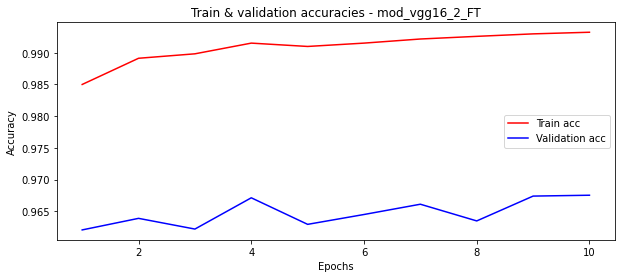

In [ ]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_vgg)
modelize(mod_vgg16_2_FT, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16_2_FT", Adam(1e-5), 1)

### **VGG sur échantillon test...**

In [ ]:
# Chargement du modèle
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_vgg16_2_FT"
mod_vgg16_2_FT = load_model(mod_path)

In [ ]:
test_gen = create_test_generators(BATCH, PATH_TEST, (224,224), prepro_vgg)

Found 8183 images belonging to 120 classes.


In [ ]:
# test du model sur les échantillons test : evaluate_generator
eval_model(mod_vgg16_2_FT, test_gen, TEST_STEPS)

256/256 [==============================] - 26s 101ms/step - loss: 21.9426 - accuracy: 0.8614
L'accuracy du model est : acc = 0.861


In [ ]:
# wtf ? 10 pts d'écart avec le modèle "tuné" ???

### **Utilisation du global average pooling sur VGG**

1.   Élément de liste
2.   Élément de liste



In [ ]:
# import vgg16 sans les couches denses
model_VGG16_ap = VGG16(weights = 'imagenet', 
                       include_top = False, 
                       input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16_ap.layers :
    layer.trainable = False

In [ ]:
# partie dense
# entrée
x = model_VGG16_ap.layers[-1].output
# applatissement
#x = Flatten()(x)
# couche Dense 120 sortie directe
x = GlobalAveragePooling2D()(x)

preds = Dense(120, activation = "softmax")(x)

# Def du modèle totale
mod_VGG16_ap = Model(inputs = model_VGG16_ap.input, outputs = preds)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 382s 165ms/step - loss: 4.4452 - accuracy: 0.4551 - val_loss: 1.0056 - val_accuracy: 0.7513
Epoch 2/5
2316/2316 [==============================] - 377s 163ms/step - loss: 0.8473 - accuracy: 0.8007 - val_loss: 0.7980 - val_accuracy: 0.7984
Epoch 3/5
2316/2316 [==============================] - 375s 162ms/step - loss: 0.6135 - accuracy: 0.8494 - val_loss: 0.6183 - val_accuracy: 0.8390
Epoch 4/5
2316/2316 [==============================] - 376s 162ms/step - loss: 0.4923 - accuracy: 0.8753 - val_loss: 0.5463 - val_accuracy: 0.8561
Epoch 5/5
2316/2316 [==============================] - 378s 163ms/step - loss: 0.4207 - accuracy: 0.8933 - val_loss: 0.5583 - val_accuracy: 0.8610
Temps d'entrainements pour 5 epochs : 1892 secondes.
Meilleure train_acc = 0.887, meilleure val_acc = 0.861



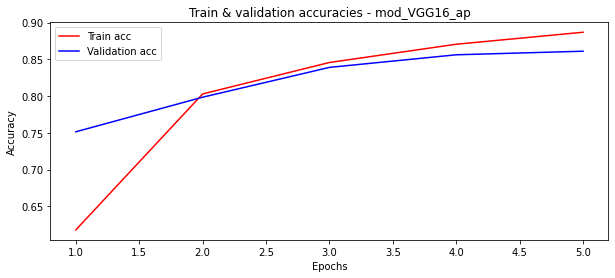

In [ ]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_vgg)
modelize(mod_VGG16_ap, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_VGG16_ap", "adam", 1)

In [ ]:
# bof, on insiste pas

### **Utilisation du max average pooling sur VGG**


In [ ]:
# import vgg16 sans les couches denses
model_VGG16_mp = VGG16(weights = 'imagenet', 
                       include_top = False, 
                       input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16_mp.layers :
    layer.trainable = False

In [ ]:
# partie dense
# entrée
x = model_VGG16_mp.layers[-1].output
# applatissement
#x = Flatten()(x)
# couche Dense 120 sortie directe
x = GlobalMaxPool2D()(x)

preds = Dense(120, activation = "softmax")(x)

# Def du modèle totale
mod_VGG16_mp = Model(inputs = model_VGG16_mp.input, outputs = preds)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 377s 163ms/step - loss: 40.4671 - accuracy: 0.3726 - val_loss: 11.7649 - val_accuracy: 0.6573
Epoch 2/5
2316/2316 [==============================] - 377s 163ms/step - loss: 9.4271 - accuracy: 0.7295 - val_loss: 8.3975 - val_accuracy: 0.7323
Epoch 3/5
2316/2316 [==============================] - 378s 163ms/step - loss: 7.4174 - accuracy: 0.7823 - val_loss: 8.0120 - val_accuracy: 0.7568
Epoch 4/5
2316/2316 [==============================] - 378s 163ms/step - loss: 6.2741 - accuracy: 0.8107 - val_loss: 7.7613 - val_accuracy: 0.7726
Epoch 5/5
2316/2316 [==============================] - 377s 163ms/step - loss: 5.5398 - accuracy: 0.8342 - val_loss: 7.5819 - val_accuracy: 0.7893
Temps d'entrainements pour 5 epochs : 1891 secondes.
Meilleure train_acc = 0.828, meilleure val_acc = 0.789



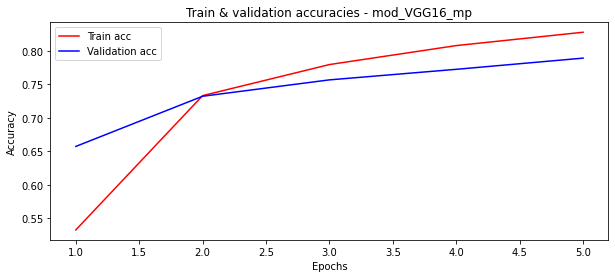

In [ ]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_vgg)
modelize(mod_VGG16_mp, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_VGG16_mp", "adam", 1)

In [ ]:
# bof...

# **InceptionResNetV2**<br>
avec images 299*299<br>les images doivent être entre 299*299 et 150*150.

In [ ]:
# import InceptionResNetV2 sans les couches denses
model_IN = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (299,299,3))

219062272/219055592 [==============================] - 3s 0us/step


In [ ]:
for layer in model_IN.layers :
    layer.trainable = False

In [ ]:
# partie dense

# entrée
x = model_IN.output
# applatissement
x = Flatten()(x)
preds = Dense(120, activation = "softmax")(x)

mod_IN = Model(inputs = model_IN.input, outputs = preds)
model_IN.output.shape

TensorShape([None, 8, 8, 1536])

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 606s 251ms/step - loss: 5.9259 - accuracy: 0.8257 - val_loss: 3.2074 - val_accuracy: 0.9335
INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep/assets
Epoch 2/10
2316/2316 [==============================] - 574s 248ms/step - loss: 2.5153 - accuracy: 0.9445 - val_loss: 3.2934 - val_accuracy: 0.9378
INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep/assets
Epoch 3/10
2316/2316 [==============================] - 579s 250ms/step - loss: 1.8753 - accuracy: 0.9603 - val_loss: 3.1568 - val_accuracy: 0.9470
INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep/assets
Epoch 4/10
2316/2316 [==============================] - 564s 244ms/step - loss: 1.4181 - accuracy: 0.9706 - val_loss: 3.0161 - val_accuracy: 0.9536
INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep/a

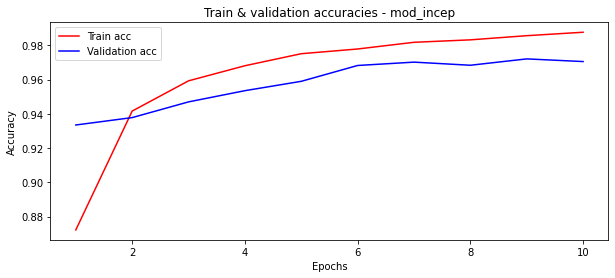

In [ ]:
# version bon format de sauvegarde
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (299, 299), prepro_in)
modelize(mod_IN, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_inception", "adam", 1)

## **Finetuning inception**

In [ ]:
# Chargement du modèle sauvegardé
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_inception"
mod_incep_FT = load_model(mod_path)

In [ ]:
print(f"Le modèle a {len(mod_incep_FT.layers)} layers différents")

Le modèle a 782 layers différents


In [ ]:
mod_incep_FT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# on bloque l'entrainement du layer dense de fin
mod_incep_FT.layers[-1].trainable = False

# on libère l'entrainement du bloc 9 et 10 de convo.
# on ne va pas plus loin car
for i in [-4, -5, -7, -11, -12, -13, -14]:

    mod_incep_FT.layers[i].trainable = True

In [ ]:
BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
#NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
#TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
#VAL_STEPS_light = TRAIN_STEPS_light // 5

print(TRAIN_STEPS, VAL_STEPS)

2316 463


Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 741s 315ms/step - loss: 1.6760 - accuracy: 0.9736 - val_loss: 2.4660 - val_accuracy: 0.9652
Epoch 2/10
2316/2316 [==============================] - 717s 310ms/step - loss: 0.5943 - accuracy: 0.9892 - val_loss: 1.5706 - val_accuracy: 0.9781
Epoch 3/10
2316/2316 [==============================] - 714s 308ms/step - loss: 0.5389 - accuracy: 0.9900 - val_loss: 1.3445 - val_accuracy: 0.9802
Epoch 4/10
2316/2316 [==============================] - 715s 309ms/step - loss: 0.3430 - accuracy: 0.9923 - val_loss: 1.6112 - val_accuracy: 0.9749
Epoch 5/10
2316/2316 [==============================] - 716s 309ms/step - loss: 0.3966 - accuracy: 0.9928 - val_loss: 1.2299 - val_accuracy: 0.9803
Epoch 6/10
2316/2316 [==============================] - 711s 307ms/step - loss: 0.3576 - accuracy: 0.9938 - val_loss: 1.2595 - val_accuracy: 0.9802
Epoch 7/10
2316/2316 [

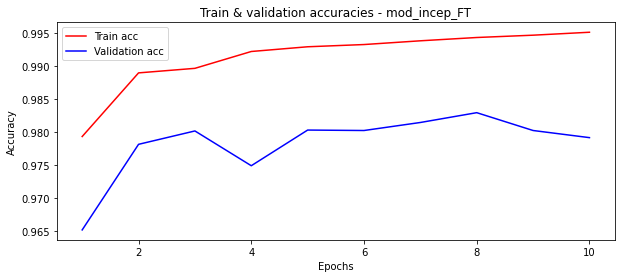

In [ ]:
# avec 1e-5 et 1e-6 gros écart au départ... on tourne avec 1e-4...
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (299, 299), prepro_in)
modelize(mod_incep_FT, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_inception_ft", Adam(1e-4), 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 1117s 474ms/step - loss: 5.2491 - accuracy: 0.9020 - val_loss: 0.4465 - val_accuracy: 0.9670
INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep_FT/assets


INFO:tensorflow:Assets written to: drive/MyDrive/P6/Data/models/mod_incep_FT/assets


Epoch 2/10
2316/2316 [==============================] - 1092s 471ms/step - loss: 0.1265 - accuracy: 0.9728 - val_loss: 0.2924 - val_accuracy: 0.9557
Epoch 3/10
2316/2316 [==============================] - 1087s 469ms/step - loss: 0.3051 - accuracy: 0.9428 - val_loss: 2.9081 - val_accuracy: 0.9131
Epoch 4/10
2316/2316 [==============================] - 1077s 465ms/step - loss: 0.2822 - accuracy: 0.9450 - val_loss: 0.6081 - val_accuracy: 0.9472
Epoch 5/10
2316/2316 [==============================] - 1084s 468ms/step - loss: 0.1981 - accuracy: 0.9553 - val_loss: 0.2439 - val_accuracy: 0.9571
Epoch 6/10
2316/2316 [==============================] - 1090s 471ms/step - loss: 0.1288 - accuracy: 0.9678 - val_loss: 0.2120 - val_accuracy: 0.9655
Epoch 7/10
2316/2316 [==============================] - 1092s 471ms/step - loss: 0.1167 - accuracy: 0.9699 - val_loss: 0.2609 - val_accuracy: 0.9555
Epoch 8/10
2316/2316 [==============================] - 1092s 471ms/step - loss: 0.1760 - accuracy: 0.9631

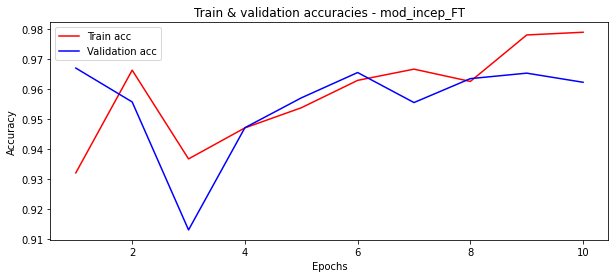

In [ ]:
# FT 2 !!!!!! (avec 1e-5 et 1e-6 gros écart au départ... on tourne avec 1e-4...)
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (299, 299), prepro_in)
modelize(mod_incep_FT, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_incep_FT", Adam(1e-4), 1)

### **Modèle inception sur échantillon test**

In [ ]:
# Chargement du modèle
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_incep_FT"
mod_incep_FT = load_model(mod_path)

In [ ]:
test_gen = create_test_generators(BATCH, PATH_TEST, (299,299), prepro_in)

Found 8183 images belonging to 120 classes.


In [ ]:
# test du model sur les échantillons test : evaluate_generator
eval_model(mod_incep_FT, test_gen, TEST_STEPS)

256/256 [==============================] - 49s 177ms/step - loss: 4.3203 - accuracy: 0.9498
L'accuracy du model est : acc = 0.950


In [ ]:
# Presque 3 pts d'écarts entre val et test acc.....................

# **EfficientNet30**<br>
On va essayer un modèle léger...<br>dim = 224*224<br>Type de modèles à sauvegarder au format H5

In [ ]:
model_EFF30 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in model_EFF30.layers :
    layer.trainable = False

In [ ]:
# partie dense
# entrée
x = model_EFF30.output
# applatissement
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
# dense 120 avec RelU
#x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

mod_EFF30 = Model(inputs = model_EFF30.input, outputs = preds)
model_EFF30.output.shape

TensorShape([None, 7, 7, 1280])

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 366s 150ms/step - loss: 7.0236 - accuracy: 0.6216 - val_loss: 2.8389 - val_accuracy: 0.8776
Epoch 2/10
2316/2316 [==============================] - 341s 147ms/step - loss: 2.2635 - accuracy: 0.9039 - val_loss: 1.8736 - val_accuracy: 0.9249
Epoch 3/10
2316/2316 [==============================] - 340s 147ms/step - loss: 1.7908 - accuracy: 0.9322 - val_loss: 2.3363 - val_accuracy: 0.9254
Epoch 4/10
2316/2316 [==============================] - 341s 147ms/step - loss: 1.5866 - accuracy: 0.9489 - val_loss: 1.8677 - val_accuracy: 0.9432
Epoch 5/10
2316/2316 [==============================] - 339s 147ms/step - loss: 1.3375 - accuracy: 0.9583 - val_loss: 1.7796 - val_accuracy: 0.9494
Epoch 6/10
2316/2316 [==============================] - 342s 148ms/step - loss: 1.1980 - accuracy: 0.9653 - val_loss: 1.7883 - val_accuracy: 0.9563
Epoch 7/10
2316/2316 [

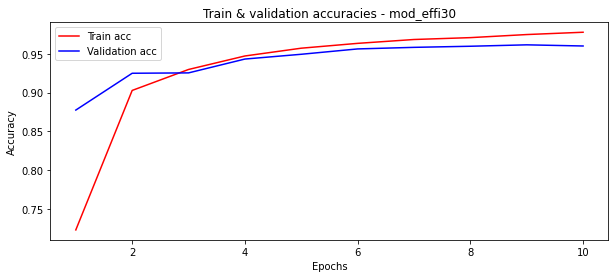

In [ ]:
# essai avec bonne sauvegarde, direct sur 10 epochs
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_eff)
modelize(mod_EFF30, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_effi30.h5", "adam", 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 354s 151ms/step - loss: 0.9618 - accuracy: 0.9775 - val_loss: 1.5255 - val_accuracy: 0.9684
Epoch 2/5
2316/2316 [==============================] - 345s 149ms/step - loss: 0.9367 - accuracy: 0.9808 - val_loss: 1.6476 - val_accuracy: 0.9658
Epoch 3/5
2316/2316 [==============================] - 343s 148ms/step - loss: 0.7969 - accuracy: 0.9824 - val_loss: 1.5753 - val_accuracy: 0.9702
Epoch 4/5
2316/2316 [==============================] - 343s 148ms/step - loss: 0.8246 - accuracy: 0.9832 - val_loss: 1.3516 - val_accuracy: 0.9725
Epoch 5/5
2316/2316 [==============================] - 343s 148ms/step - loss: 0.7825 - accuracy: 0.9846 - val_loss: 1.4960 - val_accuracy: 0.9715

Temps d'entrainements pour 5 epochs : 1732 secondes.
Meilleure train_acc = 0.984, meilleure val_acc = 0.973



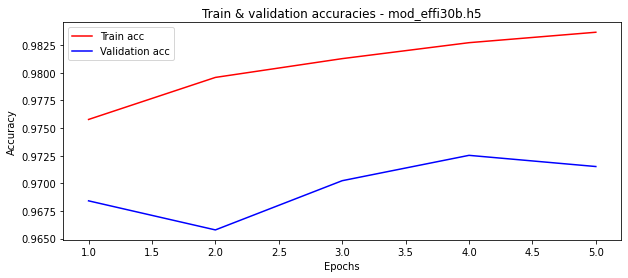

In [ ]:
# On repart pour 5 epochs supplémentaires
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_eff)
modelize(mod_EFF30, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_effi30b.h5", "adam", 1)

In [ ]:
# on s'arrête là...

## **Fine tuning EfficientNet**

In [ ]:
# Chargement du modèle
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_effi30b.h5"
mod_EFF30_ft = load_model(mod_path)

In [ ]:
print(f"Le modèle a {len(mod_EFF30_ft.layers)} layers différents")

Le modèle a 239 layers différents


In [ ]:
mod_EFF30_ft.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
# on bloque l'entrainement du layer dense de fin
mod_EFF30_ft.layers[-1].trainable = False

# on libère l'entrainement sur la fin du bloc 7a.
# on ne va pas plus loin car
for i in [-5, -7, -9, -10]: # sans batch norm [-4, -5, -6, -7, -9, -10]

    mod_EFF30_ft.layers[i].trainable = True

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 353s 151ms/step - loss: 0.6207 - accuracy: 0.9878 - val_loss: 0.9995 - val_accuracy: 0.9789
Epoch 2/5
2316/2316 [==============================] - 342s 148ms/step - loss: 0.3254 - accuracy: 0.9924 - val_loss: 0.7022 - val_accuracy: 0.9810
Epoch 3/5
2316/2316 [==============================] - 341s 147ms/step - loss: 0.2581 - accuracy: 0.9938 - val_loss: 0.6988 - val_accuracy: 0.9823
Epoch 4/5
2316/2316 [==============================] - 342s 148ms/step - loss: 0.2451 - accuracy: 0.9936 - val_loss: 0.6550 - val_accuracy: 0.9835
Epoch 5/5
2316/2316 [==============================] - 342s 148ms/step - loss: 0.2047 - accuracy: 0.9947 - val_loss: 0.5478 - val_accuracy: 0.9841

Temps d'entrainements pour 5 epochs : 1728 secondes.
Meilleure train_acc = 0.995, meilleure val_acc = 0.984



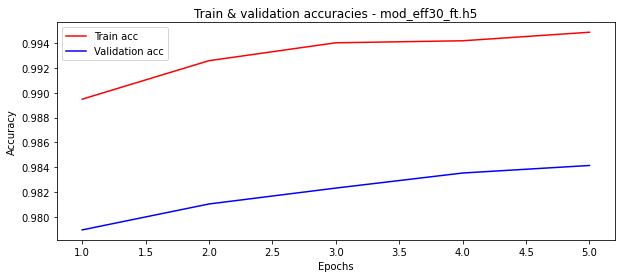

In [ ]:
# 1e-5 semble OK dès le départ...
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_eff)
modelize(mod_EFF30_ft, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_eff30_ft.h5", Adam(1e-5), 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 352s 150ms/step - loss: 0.1790 - accuracy: 0.9949 - val_loss: 0.5555 - val_accuracy: 0.9836
Epoch 2/5
2316/2316 [==============================] - 346s 149ms/step - loss: 0.1566 - accuracy: 0.9955 - val_loss: 0.4936 - val_accuracy: 0.9837
Epoch 3/5
2316/2316 [==============================] - 345s 149ms/step - loss: 0.1256 - accuracy: 0.9956 - val_loss: 0.4255 - val_accuracy: 0.9852
Epoch 4/5
2316/2316 [==============================] - 346s 149ms/step - loss: 0.1210 - accuracy: 0.9960 - val_loss: 0.5131 - val_accuracy: 0.9839
Epoch 5/5
2316/2316 [==============================] - 344s 148ms/step - loss: 0.1263 - accuracy: 0.9956 - val_loss: 0.4427 - val_accuracy: 0.9857

Temps d'entrainements pour 5 epochs : 1737 secondes.
Meilleure train_acc = 0.996, meilleure val_acc = 0.986



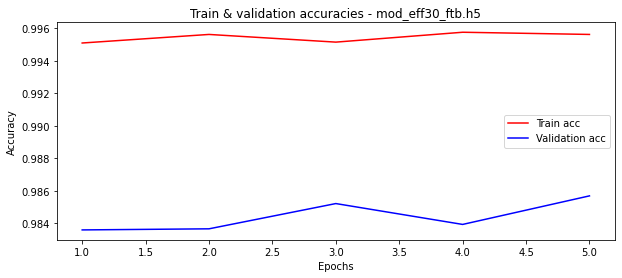

In [ ]:
# On pas d'overfitting, continue sur 5 epochs
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224), prepro_eff)
modelize(mod_EFF30_ft, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_eff30_ftb.h5", Adam(1e-5), 1)

In [ ]:
# on s'arrête là...

### **Modèle EffNet30 sur échantillon test**

In [ ]:
# Chargement du modèle
mod_path = "drive/MyDrive/P6/Data/models/" + "mod_eff30_ftb.h5"
mod_EFF_ft = load_model(mod_path)

In [ ]:
test_gen = create_test_generators(BATCH, PATH_TEST, (224,224), prepro_eff)

Found 8183 images belonging to 120 classes.


In [ ]:
# test du model sur les échantillons test : evaluate_generator
eval_model(mod_EFF_ft, test_gen, TEST_STEPS)

256/256 [==============================] - 23s 86ms/step - loss: 2.7596 - accuracy: 0.9410
L'accuracy du model est : acc = 0.941


On obtient presque 94% sur l'échantillon test, c'est à dire 1% de moins qu'avec Inception, modèle bien plus lourd qui aura été à chaque fois 2 fois plus long à entrainer.

In [ ]:
# taille du model
os.stat(mod_path).st_size / 1e6

54.110112